### Biblioteki, stałe i ładowanie danych

In [1]:
import numpy as np
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from db.gateway import ChartsGateway, ChartTracksGateway, TracksGateway

In [2]:
plt.style.use('seaborn')

In [3]:
# Load data from DB
tracks_gw = TracksGateway()
charts_gw = ChartsGateway()
df = tracks_gw.fetch_all()
df_charts = charts_gw.fetch_all()

### Wstępna eksploracja

In [4]:
df.head()

title genres  \
id                                                                              
2rPE9A1vEgShuZxxzR2tZH                                   thank u, next   None   
5p7ujcrUXASCNwRaWNHR1C                                      Without Me   None   
1A6OTy97kk0mMdm78rHsm8   Sunflower - Spider-Man: Into the Spider-Verse   None   
4w8niZpiMy6qz1mntFA5uM  Taki Taki (with Selena Gomez, Ozuna & Cardi B)   None   
6zeeWid2sgw4lap2jV61PZ                                          Better   None   

                        danceability  energy  key  loudness  mode  \
id                                                                  
2rPE9A1vEgShuZxxzR2tZH         0.724   0.647  1.0    -5.642   1.0   
5p7ujcrUXASCNwRaWNHR1C         0.752   0.488  6.0    -7.050   1.0   
1A6OTy97kk0mMdm78rHsm8         0.753   0.498  2.0    -5.610   1.0   
4w8niZpiMy6qz1mntFA5uM         0.842   0.801  8.0    -4.167   0.0   
6zeeWid2sgw4lap2jV61PZ         0.596   0.552  0.0   -10.278   0.0   

                        speechiness  acousticness  instrumentalness  liveness  \
id                                                                              
2rPE9A1vEgShuZxxzR2tZH       0.0658        0.2800          0.000000    0.1020   
5p7ujcrUXASCNwRaWNHR1C       0.0705        0.2970          0.000009    0.0936   
1A6OTy97kk0mMdm78rHsm8       0.0504        0.5510          0.000000    0.0706   
4w8niZpiMy6qz1mntFA5uM       0.2280        0.1570          0.000005    0.0642   
6zeeWid2sgw4lap2jV61PZ       0.0970        0.0765          0.334000    0.1040   

                        valence    tempo  duration_ms  time_signature  
id                                                                     
2rPE9A1vEgShuZxxzR2tZH    0.435  106.960     207333.0             4.0  
5p7ujcrUXASCNwRaWNHR1C    0.533  136.041     201661.0             4.0  
1A6OTy97kk0mMdm78rHsm8    0.927   89.950     158053.0             4.0  
4w8niZpiMy6qz1mntFA5uM    0.617   95.881     212500.0             4.0  
6zeeWid2sgw4lap2jV61PZ    0.112   97.949     229320.0             4.0

In [5]:
df.shape

(13886, 15)

In [6]:
# Max number of tracks take into account
n_total = len(df_charts)*200
print(n_total)

366200


**Wstępnie można zaobserwować występowanie tych samych utworów w ramach wielu rankingów.**

In [7]:
df_charts.groupby(by='country_code').size()

country_code
ae    345
ar    450
at    271
au    271
be    223
gl    271
dtype: int64

**Informacje o rankingach są niepełne dla takich państw jak Białoruś (3), Indie (158), Emiraty Arabskie (172), Egipt (172) oraz Izrael (208).**

In [8]:
drop_cols = ['title', 'key', 'mode', 
             'time_signature', 'genres']
df_numeric = df.drop(drop_cols, axis=1)
df_numeric.dropna(inplace=True)
features = list(df_numeric.columns)
x = df_numeric.to_numpy()
x = StandardScaler().fit_transform(x)

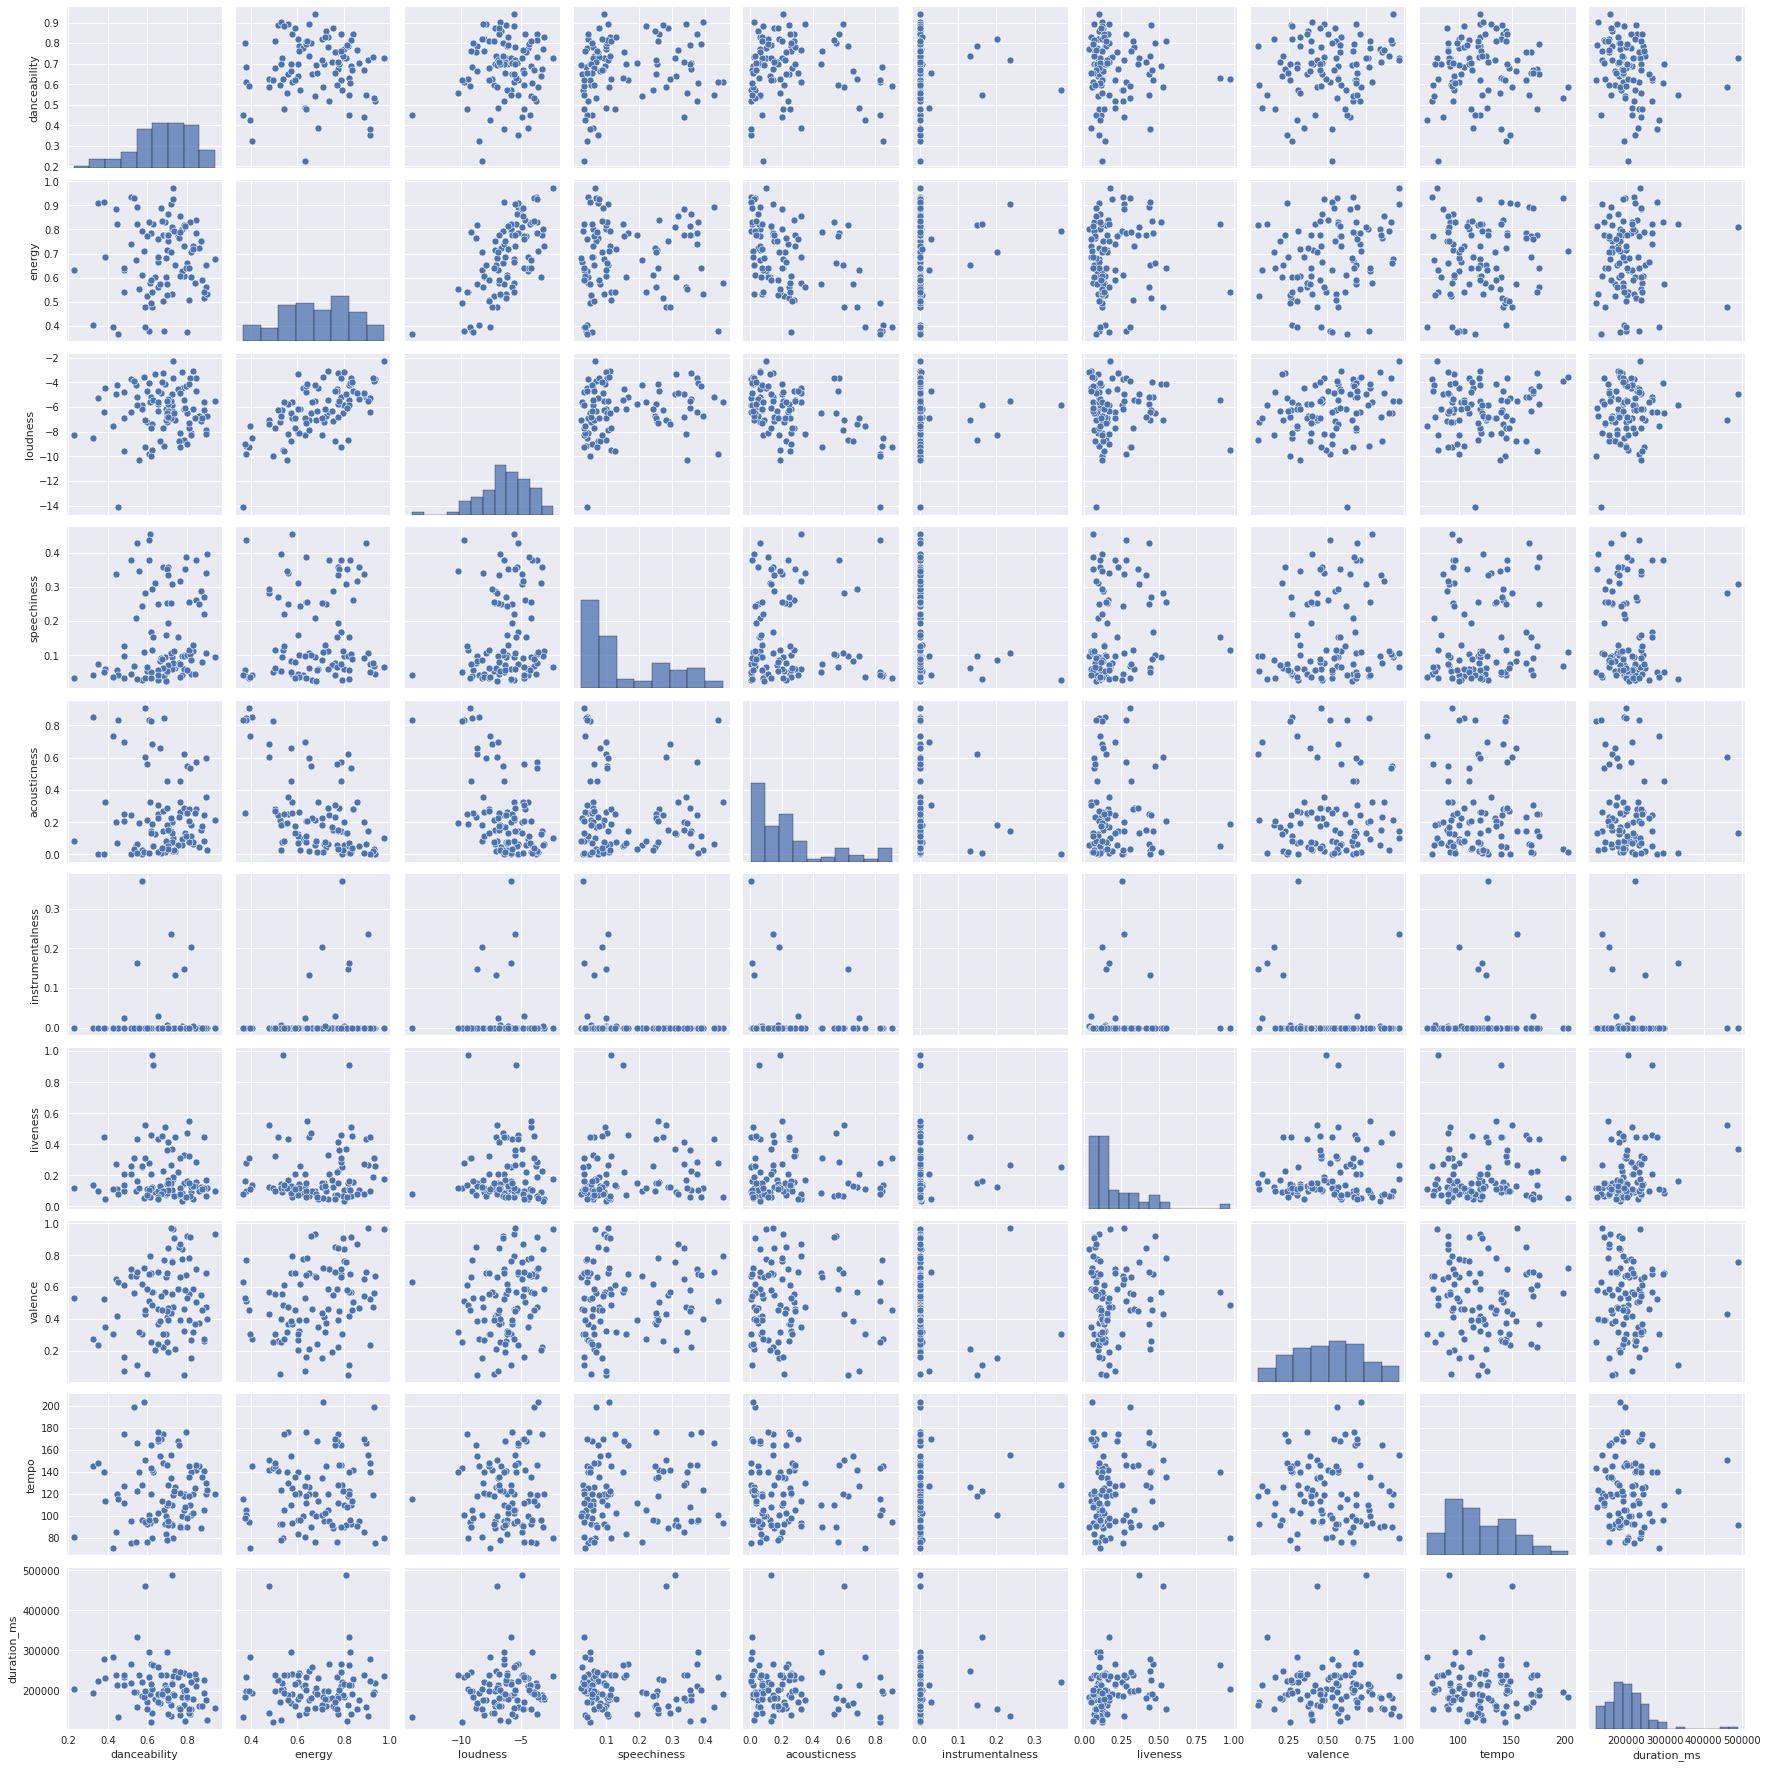

In [9]:
sns.pairplot(df.sample(n=100).drop(drop_cols, axis=1));

**Cechy audio nie są skorelowane (zauważalna korelacja jedynie dla `energy` i `loudness`), charakteryzują się różnymi rozkładami.**

### PCA

In [10]:
pca = PCA()
x_pca = pca.fit_transform(x)

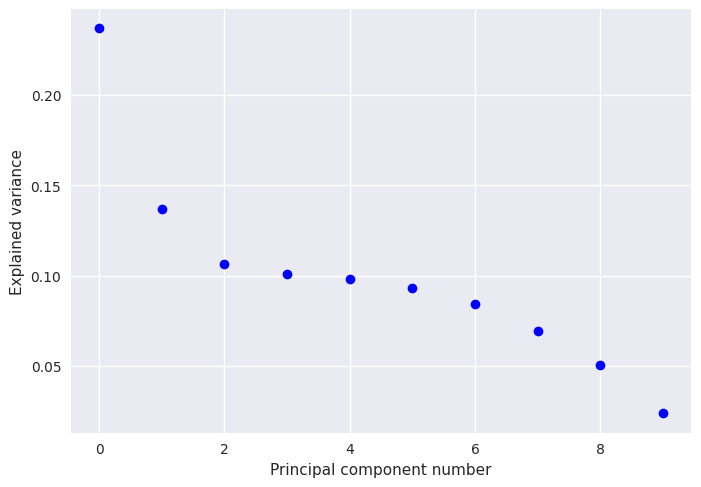

In [11]:
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.xlabel('Principal component number')
plt.ylabel('Explained variance')
plt.show()

**Poszczególne komponenty zachowują względnie dużo informacji - zbiór jest złożony.**

In [12]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
print('Attribute, PC1, PC2')

projected_features = {}

for i in range(0, pc1.shape[0]):
    print(features[i] + ' : ' + repr(pc1[i]) + ' : ' + repr(pc2[i]))
    projected_features[features[i]] = (pc1[i], pc2[i])

Attribute, PC1, PC2
danceability : -0.2540041061225541 : -0.5437376334535025
energy : -0.5550936094397664 : 0.21728437776103482
loudness : -0.5363355539001428 : 0.196282157560818
speechiness : -0.02905768722338481 : -0.4477178179146133
acousticness : 0.41886969466249535 : -0.1140532989474918
instrumentalness : 0.15402701821817605 : 0.1825566449846392
liveness : -0.07313149475548078 : 0.23426197943028013
valence : -0.35618908586950215 : -0.25187743524600825
tempo : -0.07208014227630759 : 0.028755911935786152
duration_ms : 0.04756314215588442 : 0.5026689286196419


**Wartości elementów są stosunkowo duże dla wszystkich cech, oprócz cechy `tempo`.**

In [13]:
# Scale component values down for clarity
x_pca[:, 0] /= np.amax(x_pca[:, 0])
x_pca[:, 1] /= np.amax(x_pca[:, 1])

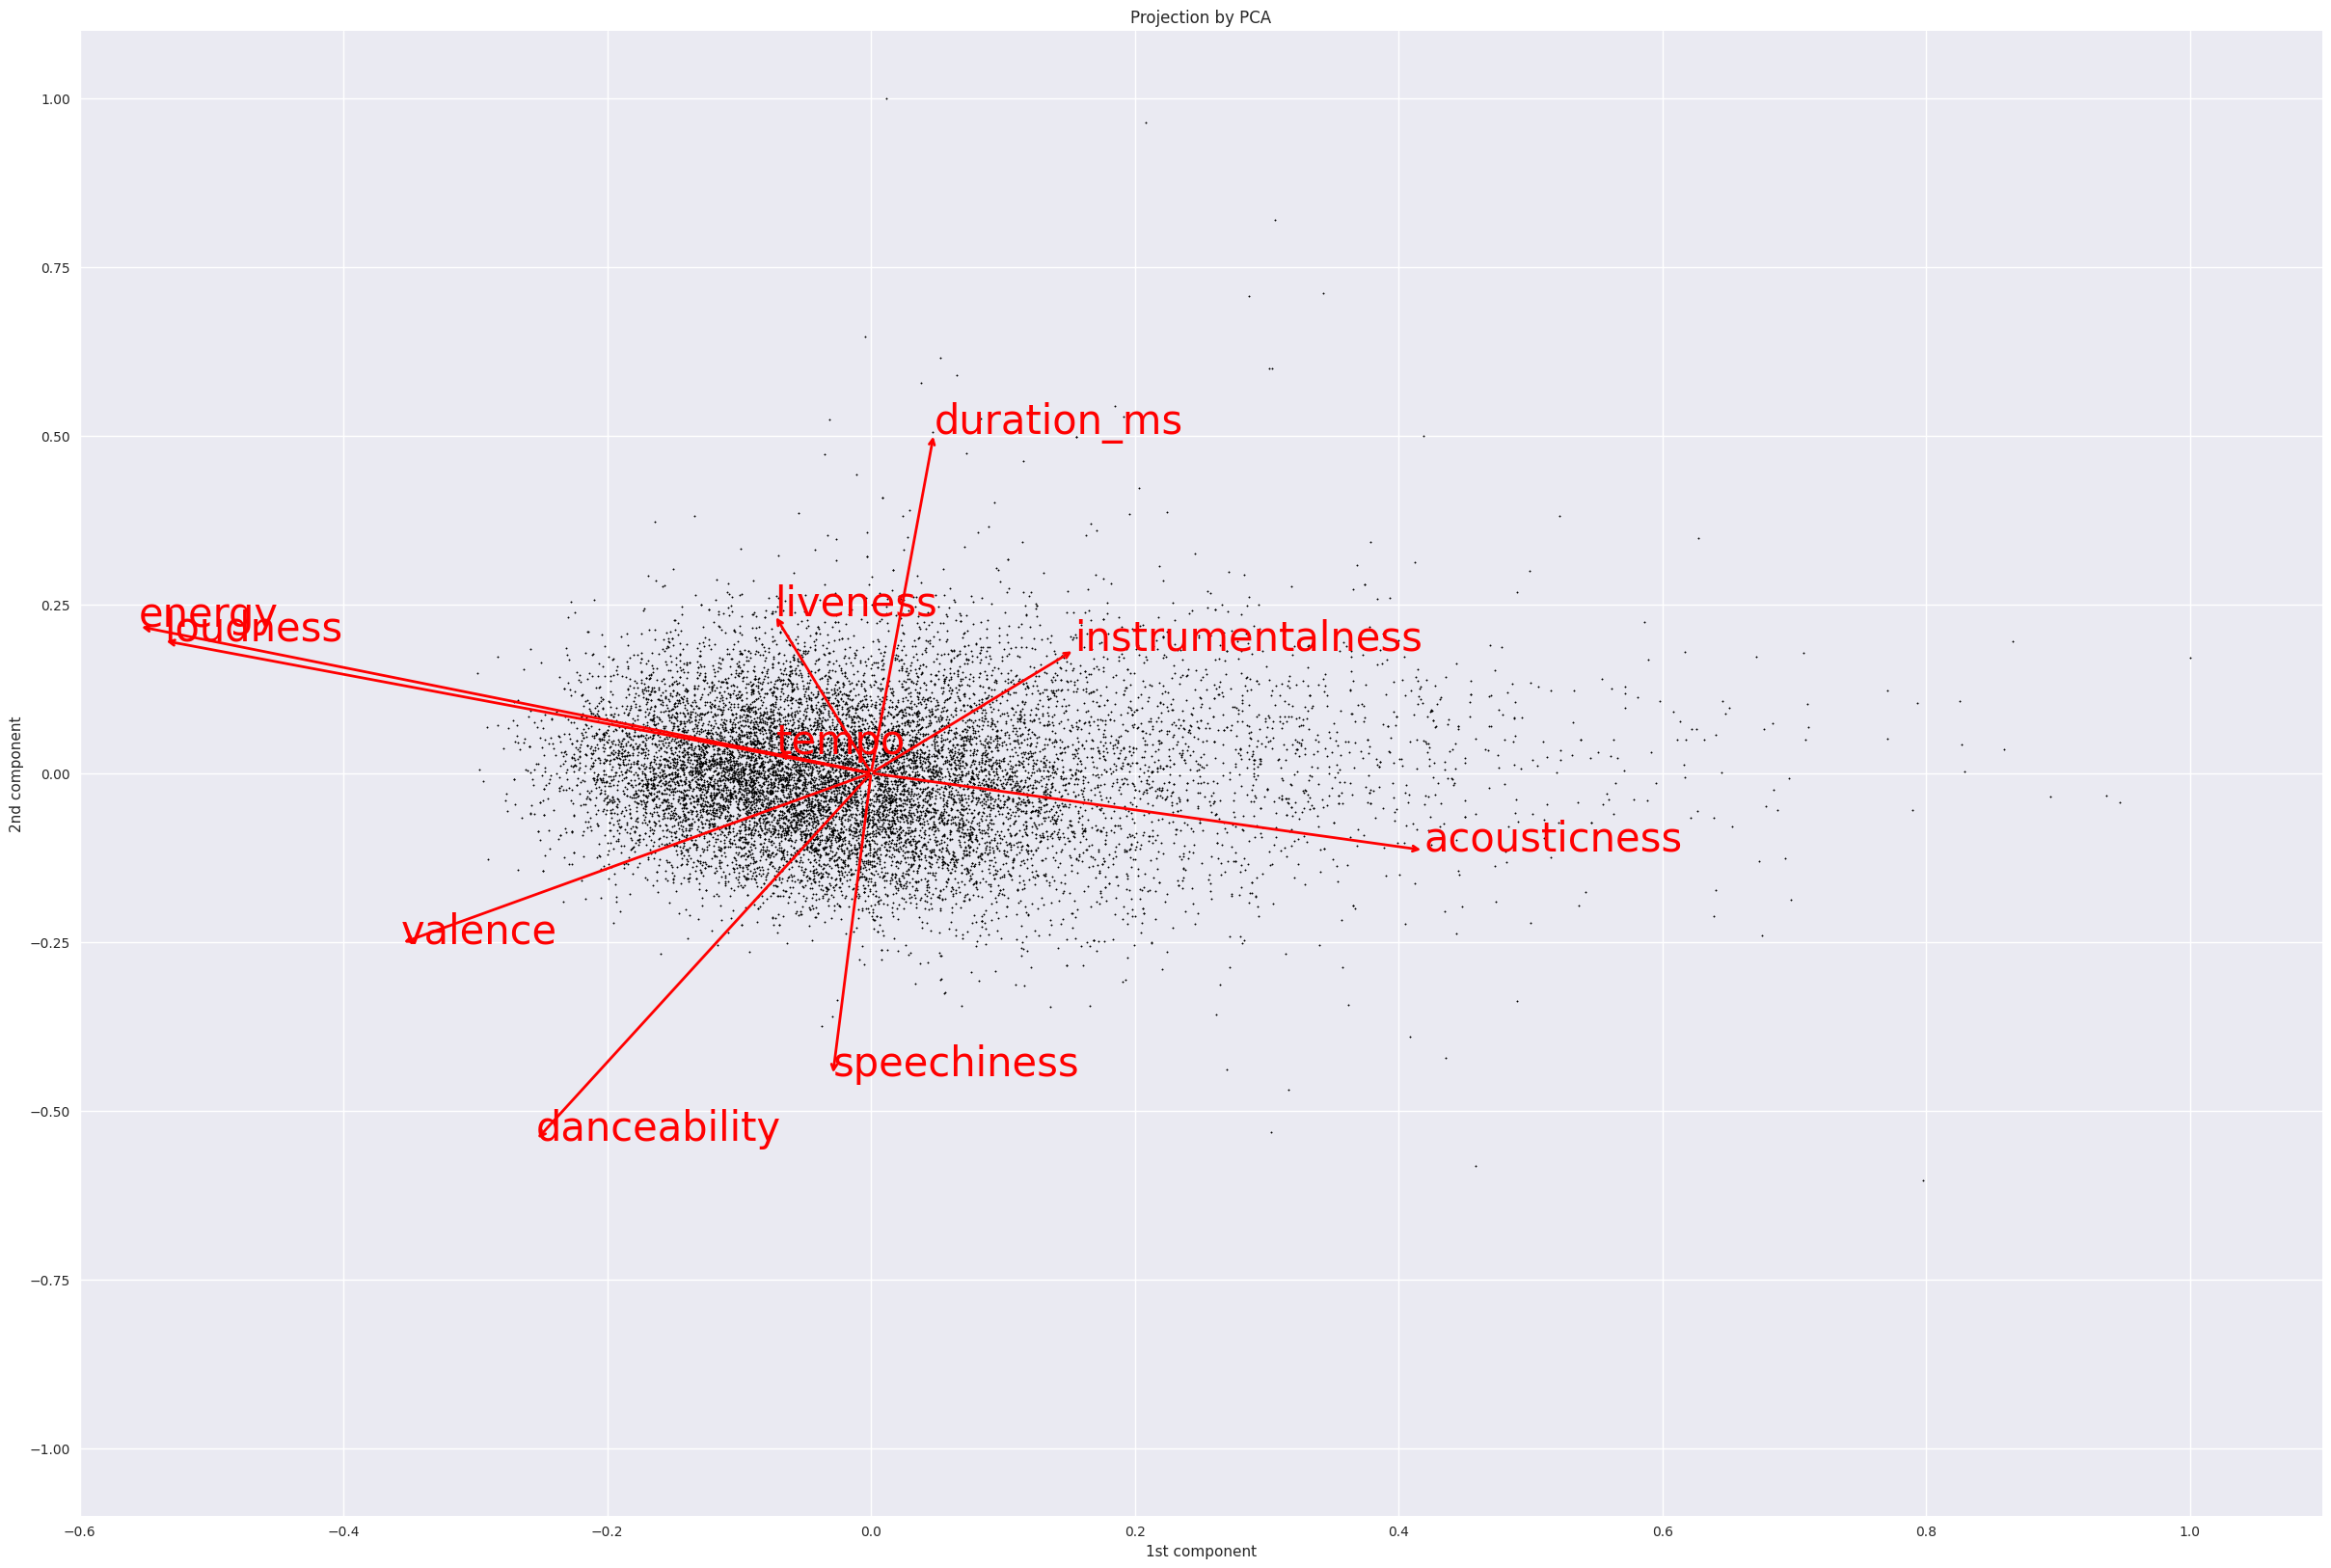

In [14]:
plt.figure(figsize=(30, 20))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c='k', s=1)

for feature_name, coords in projected_features.items():
    plt.annotate('', xy=coords, xytext=(0, 0), arrowprops=dict(arrowstyle='->', color='r', lw=2))
    plt.text(x=coords[0], y=coords[1], s=feature_name, fontsize=30, color='r')

plt.title('Projection by PCA')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.ylim(-1.1, 1.1)
plt.xlim(-0.6, 1.1)
plt.show()

**Przestrzeń jest rozciągana głównie przez to, jak utwory są głośne i energiczne oraz jak bardzo są akustyczne.**

### Zmienność cech w czasie

In [15]:
features_names = df_numeric.columns
chart_tracks_gw = ChartTracksGateway()
df_chart_tracks = chart_tracks_gw.fetch_all()
df_global = df_charts[df_charts['country_code'] == 'gl'][['date']]
df_week = df_chart_tracks \
            .merge(df_global, left_on='chart_id', right_index=True) \
            .merge(df, left_on='track_id', right_index=True)
df_means = df_week[['date', *features_names]].groupby(by='date').mean()

In [16]:
# Scale all to [0, 1] for visualization purposes
scaler = MinMaxScaler()
df_means[df_means.columns] = scaler.fit_transform(df_means.to_numpy())

In [17]:
fig = px.line(df_means, x=df_means.index, y=df_means.columns)
fig.update_layout(
    title='Średnie natężenia cech audio w czasie (rankingi globalne)',
    xaxis_title='Czas',
    yaxis_title='Natężenie cechy')
fig.show()

Obserwacje:

1. Sezonowość (Boże Narodzenie):
* coroczny spadek natężenia taneczności, energii, głośności i niewokalności utworów przed Świętami Bożego Narodzenia (i szybki wzrost przed nowym rokiem), wzrost natężenia akustyczności i pogodności utworów.


2. Trendy:
* spadek taneczności utworów (prawdopodobnie w związku z pandemią);
* spadek stosunku mowy do muzyki (prawdopodobnie z powodu wzrostu popularności podcastów i powstania dedykowanych serwisów);
* wzrost pogodności utworów od początku pandemii;
* spadek średniej długość utworów na przestrzeni ostatnich lat;
* wzrost akustyczności utworów na przestrzeni ostatnich lat.